In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

viridis = cm.get_cmap('viridis', 12)
print(viridis)
jet = cm.get_cmap('jet', 12)
print(jet)

In [2]:
print(viridis.colors)
viridis(0.8)

[[0.267004 0.004874 0.329415 1.      ]
 [0.283072 0.130895 0.449241 1.      ]
 [0.262138 0.242286 0.520837 1.      ]
 [0.220057 0.343307 0.549413 1.      ]
 [0.177423 0.437527 0.557565 1.      ]
 [0.143343 0.522773 0.556295 1.      ]
 [0.119512 0.607464 0.540218 1.      ]
 [0.166383 0.690856 0.496502 1.      ]
 [0.319809 0.770914 0.411152 1.      ]
 [0.525776 0.833491 0.288127 1.      ]
 [0.762373 0.876424 0.137064 1.      ]
 [0.993248 0.906157 0.143936 1.      ]]


(0.525776, 0.833491, 0.288127, 1.0)

In [3]:
print(jet._segmentdata)

{'red': ((0.0, 0, 0), (0.35, 0, 0), (0.66, 1, 1), (0.89, 1, 1), (1.0, 0.5, 0.5)), 'green': ((0.0, 0, 0), (0.125, 0, 0), (0.375, 1, 1), (0.64, 1, 1), (0.91, 0, 0), (1.0, 0, 0)), 'blue': ((0.0, 0.5, 0.5), (0.11, 1, 1), (0.34, 1, 1), (0.65, 0, 0), (1.0, 0, 0))}


In [4]:
from numba import cuda
import math

@cuda.jit(device=True)
def Arrow(data,image,min_,max_,V,sc,i,j):
    """Arrow making portion of plotting a vectorfield
    Parameters:
        data:  (Input)  2D Array representing a single channel image
        image: (Output) 3D Array representing RGB values
        min_:  (Input)  Specifies the minimum value in data
        max_:  (Input)  Specifies the maximum value in data
        V:     (Input)  3D Array specifying Velocity in x-y
    """
    
    scx=image.shape[0]/data.shape[0]
    scy=image.shape[1]/data.shape[1]
    
    A=1.0;
    R=16
    HS=7
    ri=int(math.floor(i/R/2)*2*R+R)
    rj=int(math.floor(j/R/2)*2*R+R)
    #//coordintates of potential vector arrow this is part of
    
    #//for(let i1=0;i1<9;i1++){
    #//ri=(Math.floor(i/R/2+i1/3-1)*2*R+R)%512
    #//rj=(Math.floor(j/R/2+i1%3-1)*2*R+R)%512
        
    #//vector representing the field arrow
    dx=(R-HS)*V[int(ri/scx)][int(rj/scy)][1]/max_[0]**0.5*sc
    dy=(R-HS)*V[int(ri/scx)][int(rj/scy)][0]/max_[0]**0.5*sc
    m=(R-HS)*((V[int(ri/scx)][int(rj/scy)][1]**2+V[int(ri/scx)][int(rj/scy)][0]**2)/max_[0])**0.5*sc
    #dx=dy=m*0.707
    hs=min(m,HS/2)
    #//now we check if our pixel is inside the arrow
    if (m>0):
        x = i-ri
        y=j-rj
        #//arrowhead can be done using inf and 1 norm in rotated coords
        X = dx*(dy-y)/m - dy*(dx-x)/m
        Y = dy*(dy-y)/m + dx*(dx-x)/m
        
        #// A<=0 if its in the arrowhead, 0<A<1 if its on the border A>1 if outside.
        A=min(A,max(-(hs-1.5*abs(X)-0.5*abs(Y)), -(hs-abs(Y+hs))));
        
        #//arrow body done by looking at length of orthogonal (to E field) part of pixel vector
        d=x*dx+y*dy
        X = x-d*dx/m/m
        Y = y-d*dy/m/m       
        if (d<m*m):
            #//Same assignment here but with the arrow body
            A=min(A,max(-3*d/hs,1-(hs/3.2-(X*X+Y*Y)**0.5)/0.4))
        #//clip A between 0 and 1
        A=max(A,0)
    return A

@cuda.jit
def SegmentedRGBArrow(data,image,min_,max_,V,sc,R,G,B):
    """Turns a [0,1] single channel image into an RGB one using a Linear Segmented colormap, then
    plots vectors from a two channel image representing vector data
    Parameters:
        data:  (Input)  2D Array representing a single channel image
        image: (Output) 3D Array representing RGB values
        min_:  (Input)  Specifies the minimum value in data
        max_:  (Input)  Specifies the maximum value in data
        V:     (Input)  3D Array specifying Velocity in x-y
        R: Red color values in linear segmented format
        G: Red color values in linear segmented format
        B: Red color values in linear segmented format
    """
    i,j=cuda.grid(2)

    #Recreating the jet colormap which specifies RGB values
    #for numbers in [0,1]
    i,j=cuda.grid(2)
    if i>=image.shape[0] or j>= image.shape[1]:return
    #gonna add upscaling real quick
    scx=image.shape[0]/data.shape[0]
    scy=image.shape[1]/data.shape[1]
    
    #Recreating the jet colormap which specifies RGB values
    #for numbers in [0,1]
    gij = (data[int(i/scx)][int(j/scy)]-min_[0])/(max_[0]-min_[0])
    
    #colormaps have the following format: 
    #[x[i] yleft[i] yright[i]] for each i in the list
    Red=0
    for ri in range(R.shape[0]-1):
        #get both x[i] anchorpoints
        L_anchor = R[ri][0]
        R_anchor= R[ri+1][0]
        #get distance between anchors
        da=R_anchor-L_anchor
        #find out if our gij is between anchors
        if L_anchor<=gij and R_anchor >= gij and da>0:
            #get the rightfacing value on the left point
            lval=R[ri][2]
            #get the leftfacing value on the left point
            rval=R[ri+1][1]
            #evaluate the color via linear interpolation
            Red = (gij-L_anchor)/da*(rval-lval)+lval
            break
    Green=0
    for ri in range(G.shape[0]-1):
        L_anchor = G[ri][0]
        R_anchor= G[ri+1][0]
        da=R_anchor-L_anchor
        if L_anchor<=gij and R_anchor >= gij and da>0:
            lval=G[ri][2]
            rval=G[ri+1][1]
            Green = (gij-L_anchor)/da*(rval-lval)+lval
            break
    Blue=0
    for ri in range(B.shape[0]-1):
        L_anchor = B[ri][0]
        R_anchor= B[ri+1][0]
        da=R_anchor-L_anchor
        if L_anchor<=gij and R_anchor >= gij and da>0:
            lval=B[ri][2]
            rval=B[ri+1][1]
            Blue = (gij-L_anchor)/da*(rval-lval)+lval
            break

    A = Arrow(data,image,min_,max_,V,sc,i,j)
        
    image[i][j][0]=Red*255*A
    image[i][j][1]=Green*255*A
    image[i][j][2]=Blue*255*A
    
    
@cuda.jit
def ListedRGBArrow(data,image,min_,max_,V,sc,colors):
    """Turns a [0,1] single channel image into an RGB one using a Linear Segmented colormap, then
    plots vectors from a two channel image representing vector data
    Parameters:
        data:  (Input)  2D Array representing a single channel image
        image: (Output) 3D Array representing RGB values
        min_:  (Input)  Specifies the minimum value in data
        max_:  (Input)  Specifies the maximum value in data
        V:     (Input)  3D Array specifying Velocity in x-y
        colors: COlors in Listed Colormap format
    """
    i,j=cuda.grid(2)

    #Recreating the jet colormap which specifies RGB values
    #for numbers in [0,1]
    i,j=cuda.grid(2)
    if i>=image.shape[0] or j>= image.shape[1]:return
    #gonna add upscaling real quick
    scx=image.shape[0]/data.shape[0]
    scy=image.shape[1]/data.shape[1]
    
    #Recreating the jet colormap which specifies RGB values
    #for numbers in [0,1]
    
    #gij is a float in [0,1]
    gij = (data[int(i/scx)][int(j/scy)]-min_[0])/(max_[0]-min_[0])
    
    #get number of colors, leftmost is for value 0, rightmost is for value 1
    nbins = colors.shape[0]
    #scale from [0,1] to [0,nbins-1]
    val=gij*(nbins-1)
    #index of the lower bound for interpolation
    bottom=int(val)
    #index of the upper bound for interpolation
    top=int(val)+1
    
    dv=(val-bottom)
    #make sure upper bound isn't too high
    if dv==0 or top==nbins:
        Red,Green,Blue=colors[bottom][0],colors[bottom][1],colors[bottom][2]
    else:
        #linearly interpolate rgb values between bins
        Red=colors[bottom][0]*(1-dv)+colors[top][0]*dv
        Green=colors[bottom][1]*(1-dv)+colors[top][1]*dv
        Blue=colors[bottom][2]*(1-dv)+colors[top][2]*dv
    A = Arrow(data,image,min_,max_,V,sc,i,j)
        
    image[i][j][0]=Red*255*A
    image[i][j][1]=Green*255*A
    image[i][j][2]=Blue*255*A
    
    
@cuda.jit
def GradientRGBArrow(data,image,min_,max_,V,sc,R,G,B):
    """Turns a [0,1] single channel image into an RGB one using a Linear Segmented colormap, then
    plots vectors from a two channel image representing vector data
    Parameters:
        data:  (Input)  2D Array representing a single channel image
        image: (Output) 3D Array representing RGB values
        min_:  (Input)  Specifies the minimum value in data
        max_:  (Input)  Specifies the maximum value in data
        V:     (Input)  3D Array specifying Velocity in x-y
        R: (Float in [0,1]) Red ratio
        G: (Float in [0,1]) Green ratio
        B: (Float in [0,1]) Blue ratio
    Note: Make sure to make at least one of R,G,B 1.0 so the image isn't needlessly dark
    """
    i,j=cuda.grid(2)

    #Recreating the jet colormap which specifies RGB values
    #for numbers in [0,1]
    i,j=cuda.grid(2)
    if i>=image.shape[0] or j>= image.shape[1]:return
    #gonna add upscaling real quick
    scx=image.shape[0]/data.shape[0]
    scy=image.shape[1]/data.shape[1]
    
    #Recreating the jet colormap which specifies RGB values
    #for numbers in [0,1]
    gij = (data[int(i/scx)][int(j/scy)]-min_[0])/(max_[0]-min_[0])
    

    A = Arrow(data,image,min_,max_,V,sc,i,j)
        
    image[i][j][0]=(gij*R)*255*A
    image[i][j][1]=(gij*G)*255*A
    image[i][j][2]=(gij*B)*255*A

# Testing the Segmented Plotting function

[[0.   0.   0.  ]
 [0.35 0.   0.  ]
 [0.66 1.   1.  ]
 [0.89 1.   1.  ]
 [1.   0.5  0.5 ]]
[[0.    0.    0.   ]
 [0.125 0.    0.   ]
 [0.375 1.    1.   ]
 [0.64  1.    1.   ]
 [0.91  0.    0.   ]
 [1.    0.    0.   ]]
[[0.   0.5  0.5 ]
 [0.11 1.   1.  ]
 [0.34 1.   1.  ]
 [0.65 0.   0.  ]
 [1.   0.   0.  ]]


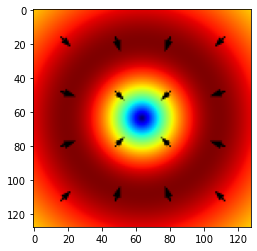

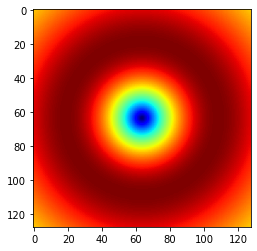

In [5]:
from matplotlib import pyplot as plt
import numpy as np
#data=jet._segmentdata
maps=cm.get_cmap('jet', 12)
print(maps)
data = maps._segmentdata
R,G,B = [np.array(data[i]) for i in data]
print(R)
print(G)
print(B)


X,Y=np.meshgrid(np.linspace(-1,1,128),np.linspace(-1,1,128))
V = 1/(X**2+Y**2+1)**0.5

u,v=np.gradient(V)
F=np.array([v,u]).transpose(1,2,0).copy()
M=(F[:,:,0]**2+F[:,:,1]**2)**0.5
im=np.zeros([128,128,3])
min_=np.ones(1)*np.min(M)
max_=np.ones(1)*np.max(M)
#jetRGBArrow[(8,8),(16,16)](M,im,min_,max_,F,4.0)
SegmentedRGBArrow[(8,8),(16,16)](M,im,min_,max_,F,4.0,R,G,B)

plt.imshow(im/255)
plt.show()
plt.imshow(M,cmap='jet')
plt.show()

# Testing the Listed Plotting

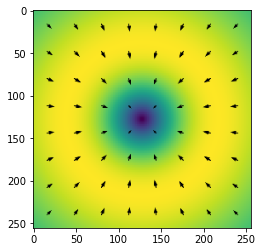

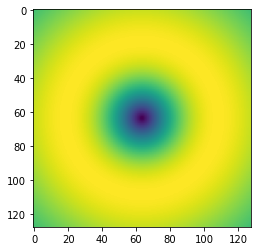

In [6]:
maps=cm.get_cmap('viridis', 12)
print(maps)
data = np.array(maps.colors)
X,Y=np.meshgrid(np.linspace(-1,1,128),np.linspace(-1,1,128))
V = 1/(X**2+Y**2+1)**0.5

u,v=np.gradient(V)
F=np.array([v,u]).transpose(1,2,0).copy()
M=(F[:,:,0]**2+F[:,:,1]**2)**0.5
im=np.zeros([256,256,3])
min_=np.ones(1)*np.min(M)
max_=np.ones(1)*np.max(M)
#jetRGBArrow[(8,8),(16,16)](M,im,min_,max_,F,4.0)
ListedRGBArrow[(16,16),(32,32)](M,im,min_,max_,F,4.0,data)

plt.imshow(im/255)
plt.show()
plt.imshow(M,cmap='viridis')
plt.show()

# Testing Gradient Plotting

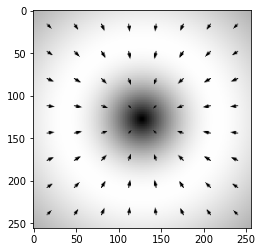

In [26]:
X,Y=np.meshgrid(np.linspace(-1,1,128),np.linspace(-1,1,128))
V = 1/(X**2+Y**2+1)**0.5
im=np.zeros([256,256,3])
GradientRGBArrow[(16,16),(32,32)](M,im,min_,max_,F,4.0,1.0,1.0,1.0)

plt.imshow(im/255)
plt.show()


# Color wheel Plotting

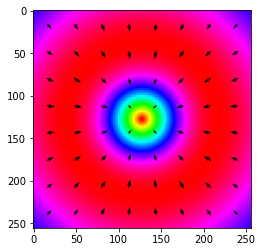

In [20]:
colorWheel = np.array([
[255,0,0,1],
[255,85,0,1],
[255,170,0,1],
[255,255,0,1],
[170,255,0,1],
[85,255,0,1],
[0,255,0,1],
[0,255,85,1],
[0,255,170,1],
[0,255,255,1],
[0,170,255,1],
[0,85,255,1],
[0,0,255,1],
[85,0,255,1],
[170,0,255,1],
[255,0,255,1],
[255,0,170,1],
[255,0,85,1],
[255,0,0,1],
])

colorWheel=colorWheel/255
im=np.zeros([256,256,3])
ListedRGBArrow[(16,16),(32,32)](M,im,min_,max_,F,4.0,colorWheel)
plt.imshow(im/255)
plt.show()

In [8]:
data=np.load("pix2pix/datasets/fieldData/validate.npz")
Efield = data["arr_2"]
Ffield = data["arr_1"]

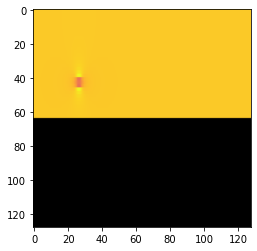

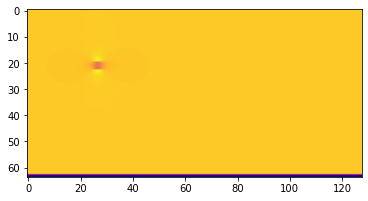

In [9]:
import matplotlib
name='plasma'
maps=cm.get_cmap(name, 12)
print(maps)
Segmented = type(maps) == matplotlib.colors.LinearSegmentedColormap
Listed = type(maps) == matplotlib.colors.ListedColormap 
#X,Y=np.meshgrid(np.linspace(-1,1,128),np.linspace(-1,1,128))
#V = 1/(X**2+Y**2+1)**0.5

#u,v=np.gradient(V)
#F=np.array([v,u]).transpose(1,2,0).copy()

F=Efield[100]

M=(F[:,:,0]**2+F[:,:,1]**2)**0.5
im=np.zeros([128,128,3])
min_=np.ones(1)*np.min(M)
max_=np.ones(1)*np.max(M)
#jetRGBArrow[(8,8),(16,16)](M,im,min_,max_,F,4.0)

if Listed:
    data = np.array(maps.colors)
    ListedRGBArrow[(4,8),(16,16)](M,im,min_,max_,F,0.0,data)
elif Segmented:
    data = maps._segmentdata
    R,G,B = [np.array(data[i]) for i in data]
    SegmentedRGBArrow[(4,8),(16,16)](M,im,min_,max_,F,0.0,R,G,B)
plt.imshow(im/255)
plt.show()
plt.imshow(M,cmap=name)
plt.show()